In [81]:
import json
import math
import os
import pathlib
import re
from collections import defaultdict
import seaborn
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import textstat
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

import warnings


In [82]:

def flesch_reading_ease(text):
    # formula=206.835-1.015(total_words/1)-84.6(syllables/total_words)
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(206.835-1.015*(words/1)-84.6*(float(syllables/words)),2)
    # print(score)
    return score

def flesch_kincaid_grade_level(text):
    # formula=0.39*(total_words/1)+11.8(syllables/total_words)-15.59
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(0.39*(words/1)+11.8*(syllables/words)-15.59,2)
    # print(score)
    return score

def total_characters(text):
    count=0
    for char in text:
        count += 1
    return count

#Remove extra white spaces, urls , mentions
def preprocess(text):
    text=text.lower()   
    # print(stopwords)
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenization_with_stemming(text):
    stemmer=PorterStemmer()
    tokens = [stemmer.stem(t) for t in text.split()]
    # print(tokens)

    return tokens

def tokenize(text):
    text = " ".join(re.split("[^a-zA-Z.,!?]*", text.lower())).strip()
    return text.split()

def set_class(text):
    if text=='NAG':
        return 2
    elif text=='OAG':
        return 1
    else:
        return 0

def preprocessing():
    path = pathlib.Path(__file__).parent.absolute()
    path = str(path)
    #Loading file set to data frame
    df=pd.read_csv(path + "\\trac-gold-set\\agr_en_fb_gold.csv", encoding = "utf-8")
    #Case folding and porter stemming
    # df["preprocess"]=df["text"].apply(lambda x:x.lower())
    df["preprocess"]=df["text"].apply(lambda x:preprocess(x))
    # print(df['preprocess'])
    df["flesch_reading_ease"]=df["text"].apply(lambda x:flesch_reading_ease(x))
    df["flesch_kincaid_grade_level"]=df["text"].apply(lambda x:flesch_kincaid_grade_level(x))
    df["syllables"]=df["text"].apply(lambda x:textstat.syllable_count(x))
    df["words"]=df["text"].apply(lambda x:textstat.lexicon_count(x))
    df["characters"]=df["text"].apply(lambda x:total_characters(x))
    df["class"]=df["aggresssion-level"].apply(lambda x:set_class(x))
    #Export processed CSV
    # print(df.text)
    df.to_csv('processed_data.csv')
    # df.describe()

def features(text):
    sentiment_analyzer=VS()
    sentiment = sentiment_analyzer.polarity_scores(text)
    
    words = preprocess(text) #Get text only
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = flesch_kincaid_grade_level(text)
    ##Modified FRE score, where sentence fixed to 1
    FRE = flesch_reading_ease(text)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(text):
    feats=[]
    for t in text:
        feats.append(features(t))
    return np.array(feats)
vectorizer = TfidfVectorizer(
    tokenizer=tokenization_with_stemming,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words='english',
    use_idf=True,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=10000,
    lowercase=True,
     token_pattern='[a-zA-Z0-9]+',
     strip_accents='unicode'
    )
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,lowercase=True,
     token_pattern='[a-zA-Z0-9]+',
     strip_accents='unicode'
    
    )
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syllables_per_sent", "num_chars", "num_chars_total",
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", 
                        "vader compound"]
stopwords = nltk.corpus.stopwords.words("english")

In [ ]:


# preprocessing()
df=pd.read_csv("test.csv")
text=df.text
tfidf = vectorizer.fit_transform(text).toarray()
features=get_feature_array(text)

#Get parts of speech tags for text and save as a string
text_tag = []
for t in text:
    tokens = tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)

pos = pos_vectorizer.fit_transform(pd.Series(text_tag)).toarray()

M = np.concatenate([tfidf,pos,features],axis=1)

In [12]:
# print(M.shape)
#Test
param_grid = [{}] # Optionally add parameters here

[[ 0.      0.      0.     ...  0.111   0.889   0.4563]
 [ 0.      0.      0.     ...  0.      0.763  -0.6876]
 [ 0.      0.      0.     ...  0.      0.478  -0.955 ]
 ...
 [ 0.      0.      0.     ...  0.204   0.796   0.4738]
 [ 0.      0.      0.     ...  0.      0.427  -0.7717]
 [ 0.      0.      0.     ...  0.187   0.813   0.5994]]


In [11]:
import pickle
with open('tfidfvectorizer.pkl', 'wb') as fin:
    pickle.dump(tfidf, fin)
with open('posvectorizer.pkl', 'wb') as fin:
    pickle.dump(pos, fin)

In [13]:
X.to_csv('Xtrain.csv')

In [2]:
M=pd.read_csv('Xtrain.csv')
X = pd.DataFrame(M)
print (M)
df=pd.read_csv("test.csv")
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4)

       Unnamed: 0    0    1    2    3         4    5    6    7    8  ...  \
0               0  0.0  0.0  0.0  0.0  7.652218  0.0  0.0  0.0  0.0  ...   
1               1  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
2               2  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
3               3  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
4               4  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
...           ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...   
24778       24778  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
24779       24779  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
24780       24780  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
24781       24781  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
24782       24782  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   

        10910  10911  10912  10913  10914  10915  10916  10917  10918   10919  
0      

In [34]:
print(y_test   )

2281     1
15914    1
18943    2
16407    1
13326    1
        ..
8509     0
16174    1
22633    1
24477    0
10918    1
Name: class, Length: 9914, dtype: int32


In [3]:
model=LogisticRegression(penalty='l2',solver='newton-cg',n_jobs=6)

In [4]:
model = model.fit(X_train, y_train)

In [6]:
import pickle
with open('trained_model.pkl', 'wb') as fin:
    pickle.dump(model, fin)

In [9]:
model.score(X_test,y_test)

0.8527335081702643

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.86213853 0.85776732 0.85608608 0.86247478 0.85368315]


In [12]:
y_preds = model.predict(X_test)

In [13]:
report = classification_report( y_test, y_preds )

In [14]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       572
           1       0.91      0.92      0.91      7664
           2       0.76      0.76      0.76      1678

    accuracy                           0.85      9914
   macro avg       0.66      0.65      0.65      9914
weighted avg       0.85      0.85      0.85      9914



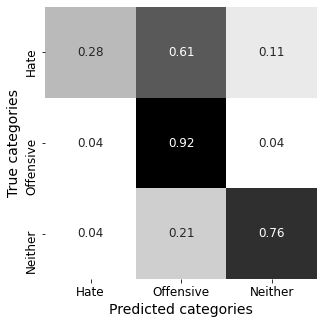

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In [ ]:

import joblib

#to save it
with open("trained_model.pkl", "w") as f:
    pkl.dump(model, f)



In [23]:
print(scores)

[0.86213853 0.85776732 0.85608608 0.86247478 0.85368315]


In [28]:
tp=0
#RUN FROM HERE
loaded_model = pickle.load(open('trained_model.pkl', 'rb'))


In [105]:
re=loaded_model.predict(X_test)
report = classification_report( y_test, re )
print(report)
print(X_test.shape)
print(y_test.shape)

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       572
           1       0.91      0.92      0.91      7664
           2       0.76      0.76      0.76      1678

    accuracy                           0.85      9914
   macro avg       0.66      0.65      0.65      9914
weighted avg       0.85      0.85      0.85      9914

(9914, 10921)
(9914,)


In [84]:
df=pd.read_csv("input.csv")
text=df.text
tfidf=vectorizer.fit_transform(text).toarray()
features=get_feature_array(text)
text_tag = []
for t in text:
    tokens = tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)
pos = pos_vectorizer.fit_transform(pd.Series(text_tag)).toarray()
M = np.concatenate([tfidf,pos,features],axis=1)

C:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warn

In [109]:
print(M)
X = pd.DataFrame(M)
df=pd.read_csv("test.csv")
y = df['class'].astype(int)
train, test = train_test_split(X,y)

[[ 1.      1.      1.      1.      1.      1.      1.      1.      1.
   1.      1.      1.      5.      1.      1.      4.      4.      1.
   1.      1.      4.      2.      1.      1.      2.      2.     21.
   1.      1.      1.      1.      1.      1.     14.      1.      1.
   8.      1.      1.      1.      1.      1.      1.      1.      1.
   1.      1.      1.      1.      1.      1.      1.      3.      2.
   1.      1.      1.      1.      1.      1.      1.      6.28   66.1
  14.      1.5555 45.     45.      9.      9.      9.      0.      0.463
   0.537   0.7221]]


ValueError: Found input variables with inconsistent numbers of samples: [1, 24783]